In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/my_lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def linear(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

def SFR_Mz_2dinterp(M,z,SFR_file):
    '''
    Returns SFR(M,z) interpolated from tables of 1+z, log10(Mhalo/Msun) and 
    log10(SFR / (Msun/yr)), in three columns, where 1+z is the innermost index 
    (the one running fast compared with the mass)
    '''
    #SFR_folder = os.path.dirname(os.path.realpath(__file__)).split("source")[0]+'SFR_tables/'
    #try:
    #    x = np.loadtxt(SFR_folder+SFR_file)
    #except:
    x = np.loadtxt(SFR_file)
    zb = np.unique(x[:,0])-1.
    logMb = np.unique(x[:,1])
    logSFRb = x[:,2].reshape(len(zb),len(logMb),order='F')
    
    logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)
    
    if 'sfr_table_Behroozi' in SFR_file:
        M *= 0.678
        
    try:
        logM = np.log10((M).value)
    except:
        logM = np.log10(M)
    if np.array(z).size>1:
        SFR = np.zeros(logM.size)
        for ii in range(0,logM.size):
            SFR[ii] = 10.**logSFR_interp(logM[ii],z[ii])
    else:
        SFR = 10.**logSFR_interp(logM,z)
    
    return SFR

def Gauss(x,mu,sig2):
    '''
    Gaussian PDF
    '''
    exparg = -0.5*x**2/sig2
    norm = (2.*np.pi*sig2)**0.5
    return np.exp(exparg)/norm

def Add_noise(T,Tout,PT,Pzero,sig2):
    '''
    Adds a noise PDF to a given PDF convoluting them
    
    params: 
    T: temperature vector
    PT: PDF of temperature
    Pzero: The value of P(T=0) (i.e., P(N=0))
    sig2: variance of the noise PDF
    '''
    conv = np.zeros(len(Tout))*PT.unit
    for i in range(len(Tout)):
        conv[i] = np.trapz(Gauss(Tout[i]-T,0.,sig2)*PT,T)
    conv += Pzero*Gauss(Tout,0.,sig2)
    
    return conv

def get_VID(M, NTbins):
    #Compute Bnoise
    sig2 = M.sigma_N**2
    Nsigma = 7
    Tmax = max(Nsigma*sig2.value**0.5,M.T[-1].value)
    TTe = np.linspace(-Nsigma*sig2.value**0.5,Tmax,2**15)*M.T.unit
    TT = vut.binedge_to_binctr(TTe)
    dTT = np.diff(TTe)

    PTN = Gauss(TT,0.,sig2).to((TT**-1).unit)

    Tmin_i,Tmax_i,nT_i = -15*u.K,50*u.K,NTbins
    Tbin_edge=np.linspace(Tmin_i, Tmax_i, nT_i+1)
    Tbin=(Tbin_edge[:-1]+Tbin_edge[1:])/2.

    n0=int(2e5)
    TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,n0)*M.T.unit,M.T))
    ind_mean=int(np.argmin(np.abs(TT2-M.Tmean)))
    PT=np.concatenate((np.concatenate((np.zeros(n0-(ind_mean-n0))*M.PT.unit,M.PT)), np.zeros(ind_mean-n0)*M.PT.unit))
    #TT2=np.concatenate((np.linspace(-Nsigma*sig2.value**0.5,0,400)*M.T.unit,M.T))
    #PT=np.concatenate((np.zeros(400)*M.PT.unit,M.PT))
    
    #get PTtot convoluting both
    Toute = np.linspace(-Nsigma*sig2.value**0.5,M.Tedge[-1].value,2**8+1)*M.T.unit
    #TTe = np.logspace(np.log10(M.Tedge[0].value),np.log10(M.Tedge[-1].value),2**15+1)*M.T.unit
    Tout = vut.binedge_to_binctr(Toute)

    PT_total = Add_noise(TT2,Tout,PT,M.PT_zero,sig2)

    Balpha_tot_overNvox = vut.pdf_to_histogram(Tout,PT_total,Tbin_edge,1,0.*Tbin.unit,0.)
    Bi=Balpha_tot_overNvox*M.Nvox
    
    return Tbin, Bi

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, sfr_pars, Tsys):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    Z=2.9
    DZ=1
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file=SFR_file,sig_SFR=0.5, 
                                       SFR_pars=sfr_pars),
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=True, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10, 
                        Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                        Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                        dndL_Lcut=20*u.Lsun)
    obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=1000, 
                      beam_FWHM=4*u.arcmin, 
                      tobs=10000*u.hr,
                      Omega_field=11.1*u.deg**2, 
                      Nfield=1)
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 3.4
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.02*u.Mpc**-1)
    obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                    RAObs_min=-10*u.deg,RAObs_max=10*u.deg,
                    DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                    RA_min=-10*u.deg,RA_max=10*u.deg,
                    DEC_min=-10*u.deg,DEC_max=10*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin, 
                    dnu=15.6*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_smooth=True)
    obs_params.update(model_params)
    return obs_params

### DC SFR parametrization and setting SFR params

In [4]:
def sfr_dc(m, A, B, C, M_h):
    '''
    Parametrization for SFR(M) based off of 2111.05931 parametrization.
    Equation is: 
    
    SFR(M) = C / ((M/M_h)**A + (M/M_h)**B)
    
    so
    A = low-M slope
    B = high-M slope
    C = amplitude at tilt scale
    M_h = tilt mass
    
    
    Note original use is for L_CO (M_h) but here we'll 
    choose SFR(M_h) instead. Should be equivalent but double check.
    '''
    ratio = m/10**M_h
    
    return np.log10(C/(ratio**A + ratio**B))

In [5]:
m_bwc = lim(lim_params('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_Behroozi.dat','other', 10))

logM=np.log10(m_bwc.M.value)
sfr_um = SFR_Mz_2dinterp(10**logM, m_bwc.z,'/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat')
sfr_bwc = SFR_Mz_2dinterp(10**logM,m_bwc.z,'/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/preLIMinary/SFR_tables/sfr_table_Behroozi.dat')          

In [6]:
popt_um, pcov = curve_fit(sfr_dc, 10**logM[np.logical_and(np.log10(sfr_um)>-3 , logM>10.5)], np.log10(sfr_um)[np.logical_and(np.log10(sfr_um)>-3, logM>10.5)],
                         p0=[3,-1.4,10,12.5])
popt_bwc, pcov = curve_fit(sfr_dc, 10**logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3],
                          p0=[3,-1.4,10,12.5])

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


(-2.0, 3.0)

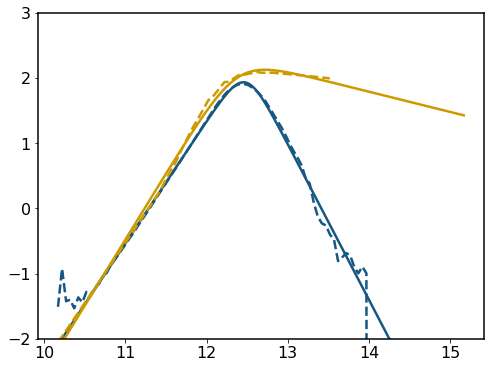

In [7]:
A_um, B_um, C_um, Mh_um = popt_um
plt.plot(logM,sfr_dc(10**logM, A_um, B_um, C_um, Mh_um), 'C0')
plt.plot(logM, np.log10(sfr_um), 'C0--')

A_bwc, B_bwc, C_bwc, Mh_bwc = popt_bwc
plt.plot(logM, sfr_dc(10**logM, A_bwc, B_bwc, C_bwc, Mh_bwc), 'C1')
plt.plot(logM[np.log10(sfr_bwc)>-3], np.log10(sfr_bwc)[np.log10(sfr_bwc)>-3], '--C1')

plt.ylim(-2, 3)

## Setting parameters for lim and lightcones

In [8]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
model_um=dict(A=A_um, B=B_um, C=C_um, M_h=(10**Mh_um)*u.Msun)

m_bwc = lim(lim_params('Chung', model_bwc, 10))
m_um = lim(lim_params('Chung', model_um, 10))

In [9]:
Ti_bwc, Bi_bwc=get_VID(m_bwc, 50)
Ti_um, Bi_um=get_VID(m_um, 50)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


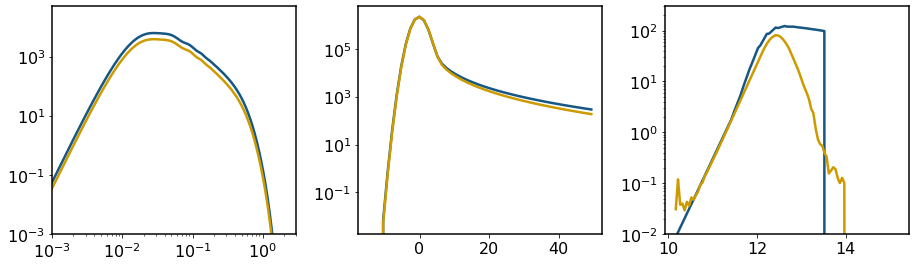

In [10]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.loglog(m_bwc.k, m_bwc.Pk_0)
plt.loglog(m_um.k, m_um.Pk_0)
plt.ylim(1e-3, 5e4)
plt.xlim(1e-3, 3)

plt.subplot(1,3,2)
plt.plot(Ti_bwc, Bi_bwc)
plt.plot(Ti_um, Bi_um)
plt.yscale('log')
#plt.ylim(1e-3, 1e4)
#plt.xlim(1e-3, 3)

plt.subplot(1,3,3)
plt.plot(logM, sfr_bwc)
plt.plot(logM, sfr_um)
plt.yscale('log')
plt.ylim(1e-2, 3e2)
plt.tight_layout()

## Lightcone

Load the full lightcone with $\Omega_{field} = 400$ deg$^2$ and compute the VID for the BWC SFR first.

In [15]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)
LC = make_measurements(LC_params(True, 'Dongwoo_SFR', model_bwc, 10*np.sqrt((11.1/400))))
bwc_map=np.asarray(LC.obs_3d_map)

#model_um=dict(A=A_um, B=B_um, C=C_um, M_h=10**Mh_um)
#LC.update(SFR_pars=model_um)
#um_map=np.asarray(LC.obs_3d_map)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

KeyboardInterrupt: 

In [ ]:
# VID of the total field
Ti_edge=np.linspace(-15, 50, 51)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

Bi_LCbwc=np.histogram(bwc_map.flatten(), bins=Ti_edge)[0]

### Full area vs subfields

To check that the division into subfields works as expected, we will divide the larger map and show that the VID of the subfields is the same as the total field. We divide the larger map into 36 subfields of 11.1 deg$^2$ each

In [13]:
LC.update(Tsys=10*u.K)
cut_edges=np.linspace(-10, 10, 7)
maps_cut=[]
for i in range(len(cut_edges)-1):
    for j in range(len(cut_edges)-1):
        LC.update(RAObs_min=cut_edges[i]*u.deg,RAObs_max=cut_edges[i+1]*u.deg,
                  DECObs_min=cut_edges[j]*u.deg,DECObs_max=cut_edges[j+1]*u.deg)
        map_tmp=np.asarray(LC.obs_3d_map)
        maps_cut.append(map_tmp)

In [60]:
Bi_cut=[]
for i in range(len(maps_cut)):
    Bi_cut.append(np.histogram(maps_cut[i].flatten(), bins=Ti_edge)[0])

In [72]:
#comparing the full field with LIM
m_bwc.update(Omega_field=400*u.deg**2, Tsys_NEFD=10*np.sqrt((11.1/400))*u.K)
Ti_bwc, Bi_LIMbwc=get_VID(m_bwc)

/home-2/gsatopo1@jhu.edu/library/lim/source/tools/_vid_tools.py:77: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  h[ii] = quad(PTi,Tedge[ii].value,Tedge[ii+1].value)[0]*Nvox
/home-2/gsatopo1@jhu.edu/library/lim/source/tools/_vid_tools.py:77: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  h[ii] = quad(PTi,Tedge[ii].value,Tedge[ii+1].value)[0]*Nvox
/home-2/gsatopo1@jhu.edu/library/lim/source/line_model.py:741: RuntimeWarning: divide by zero encountered in log
  CL

Note: redshifts have been re-sorted (earliest first)


/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


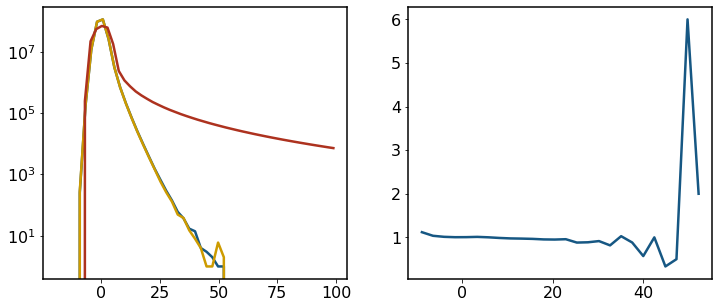

In [75]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Ti, Bi_LCbwc)
plt.plot(Ti, np.sum(Bi_cut, axis=0))
plt.plot(Ti_bwc, Bi_LIMbwc)
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(Ti, np.sum(Bi_cut, axis=0)/Bi_LCbwc)

### Derivative of the subfields
Take numerical derivatives of the subfields and average over them

In [14]:
maps_plus=[]
maps_minus=[]
for i in range(len(cut_edges)-1):
    for j in range(len(cut_edges)-1):
        LC.update(RAObs_min=cut_edges[i]*u.deg,RAObs_max=cut_edges[i+1]*u.deg,
                  DECObs_min=cut_edges[j]*u.deg,DECObs_max=cut_edges[j+1]*u.deg)
        
        LC.update(SFR_pars=dict(A=A_bwc*(1.05), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
        maps_plus.append(np.asarray(LC.obs_3d_map))
        print(LC.RAObs_min, LC.RAObs_max, LC.DECObs_min, LC.DECObs_max, LC.SFR_pars)
        
        LC.update(SFR_pars=dict(A=A_bwc*(0.95), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
        maps_minus.append(np.asarray(LC.obs_3d_map))
        print(LC.SFR_pars)

-10.0 deg -6.666666666666666 deg -10.0 deg -6.666666666666666 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
-10.0 deg -6.666666666666666 deg -6.666666666666666 deg -3.333333333333333 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
-10.0 deg -6.666666666666666 deg -3.333333333333333 deg 0.0 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
-10.0 deg -6.666666666666666 deg 0.0 deg 3.333333333333334 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A

{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
6.666666666666668 deg 10.0 deg -10.0 deg -6.666666666666666 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
6.666666666666668 deg 10.0 deg -6.666666666666666 deg -3.333333333333333 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
6.666666666666668 deg 10.0 deg -3.333333333333333 deg 0.0 deg {'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': 2336351854320.663}
6.666666666666668 deg 10.0 deg 0.0 deg 3.333333333333334 deg {'A': 0.3258

In [15]:
np.save('../../maps_cut_fid', maps_cut)

In [18]:
np.save('../../maps_cut_Aplus', maps_plus)
np.save('../../maps_cut_Aminus', maps_minus)

In [109]:
# VID of the total field
Ti_edge=np.linspace(-15, 50, 31)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

deriv_cut=[]
for i in range(len(maps_cut)):
    Bi_plus=np.histogram(maps_plus[i].flatten(), bins=Ti_edge)[0]
    Bi_minus=np.histogram(maps_minus[i].flatten(), bins=Ti_edge)[0]
    deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))

We also compare our results with the analytical derivative computed with lim

In [40]:
bwc_plus=dict(A=A_bwc*1.05, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_plus))
_, Bi_LIMplus=get_VID(m_bwc, 30)

bwc_minus=dict(A=A_bwc*0.95, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_minus))
Ti_bwc, Bi_LIMminus=get_VID(m_bwc, 30)

deriv_LIM=(Bi_LIMplus-Bi_LIMminus)/(A_bwc*0.1)

UnitTypeError: Can only apply 'log' function to dimensionless quantities

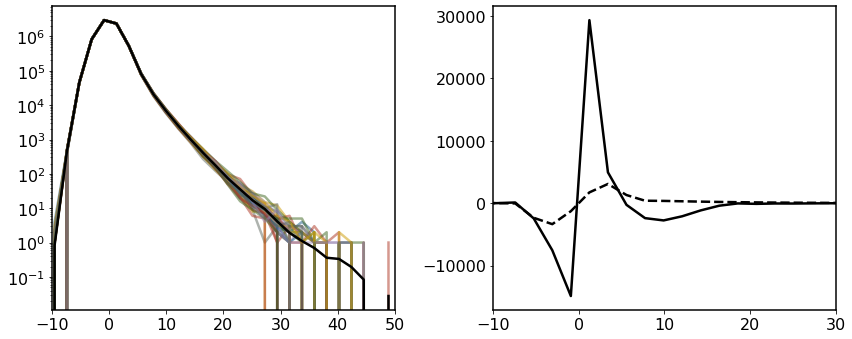

In [112]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i in range(len(Bi_cut)):
    plt.plot(Ti, Bi_cut[i], alpha=0.5)
plt.plot(Ti, np.average(Bi_cut, axis=0), 'k')
plt.yscale('log')
plt.xlim(-10, 50)

plt.subplot(1,2,2)
#for i in range(len(deriv_cut)):
#    plt.plot(Ti, deriv_cut[i], alpha=0.5)
plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)
plt.tight_layout()
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.


In [62]:
Nvox=LC.Nchan*LC.Npix
varBi_cut=np.asarray([Bi_cut[i]*(1-Bi_cut[i]/Nvox) for i in range(len(Bi_cut))])

In [72]:
Nfields=[16, 26, 36]

Bi_N10=[]; deriv_N10=[]
Bi_N25=[]; deriv_N25=[]
Bi_N50=[];deriv_N50=[]
T10_edge=np.linspace(-15, 50, 11)
T10=(T10_edge[:-1]+T10_edge[1:])/2.
T25_edge=np.linspace(-15, 50, 26)
T25=(T25_edge[:-1]+T25_edge[1:])/2.
T50_edge=np.linspace(-15, 50, 51)
T50=(T50_edge[:-1]+T50_edge[1:])/2.

Bi10_cut=[]; Bi25_cut=[]; Bi50_cut=[]
deriv10_cut=[]; deriv25_cut=[]; deriv50_cut=[]
for n in range(36):
    Bi10_plus=np.histogram(maps_plus[n].flatten(), bins=T10_edge)[0]
    Bi10_minus=np.histogram(maps_minus[n].flatten(), bins=T10_edge)[0]
    Bi25_plus=np.histogram(maps_plus[n].flatten(), bins=T25_edge)[0]
    Bi25_minus=np.histogram(maps_minus[n].flatten(), bins=T25_edge)[0]
    Bi50_plus=np.histogram(maps_plus[n].flatten(), bins=T50_edge)[0]
    Bi50_minus=np.histogram(maps_minus[n].flatten(), bins=T50_edge)[0]

    deriv10_cut.append((Bi10_plus-Bi10_minus)/(A_bwc*0.1))
    deriv25_cut.append((Bi25_plus-Bi25_minus)/(A_bwc*0.1))
    deriv50_cut.append((Bi50_plus-Bi50_minus)/(A_bwc*0.1))
    Bi10_cut.append(np.histogram(maps_plus[n].flatten(), bins=T10_edge)[0])
    Bi25_cut.append(np.histogram(maps_plus[n].flatten(), bins=T25_edge)[0])
    Bi50_cut.append(np.histogram(maps_plus[n].flatten(), bins=T50_edge)[0])
    if n==15:
        deriv_N10.append(np.average(deriv10_cut, axis=0))
        deriv_N25.append(np.average(deriv25_cut, axis=0))
        deriv_N50.append(np.average(deriv50_cut, axis=0))
        Bi_N10.append(np.average(Bi10_cut, axis=0))
        Bi_N25.append(np.average(Bi25_cut, axis=0))
        Bi_N50.append(np.average(Bi50_cut, axis=0))
    if n==25:
        deriv_N10.append(np.average(deriv10_cut, axis=0))
        deriv_N25.append(np.average(deriv25_cut, axis=0))
        deriv_N50.append(np.average(deriv50_cut, axis=0))
        Bi_N10.append(np.average(Bi10_cut, axis=0))
        Bi_N25.append(np.average(Bi25_cut, axis=0))
        Bi_N50.append(np.average(Bi50_cut, axis=0))
    if n==35:
        deriv_N10.append(np.average(deriv10_cut, axis=0))
        deriv_N25.append(np.average(deriv25_cut, axis=0))
        deriv_N50.append(np.average(deriv50_cut, axis=0))
        Bi_N10.append(np.average(Bi10_cut, axis=0))
        Bi_N25.append(np.average(Bi25_cut, axis=0))
        Bi_N50.append(np.average(Bi50_cut, axis=0))

In [120]:
Nbins=[10,25,50]
deriv_LIM=[]
Bi_Nbins=[]
for i in range(len(Nbins)):
    bwc_plus=dict(A=A_bwc*1.05, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_plus))
    _, Bi_LIMplus=get_VID(m_bwc, Nbins[i])

    bwc_minus=dict(A=A_bwc*0.95, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_minus))
    Ti_bwc, Bi_LIMminus=get_VID(m_bwc, Nbins[i])

    deriv_LIM.append((Bi_LIMplus-Bi_LIMminus)/(A_bwc*0.1))
    
    bwc_fid=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_fid))
    Ti_bwc, Bi_LIM=get_VID(m_bwc, Nbins[i])
    Bi_Nbins.append(Bi_LIM)

Note: redshifts have been re-sorted (earliest first)


In [129]:
np.cumsum(deriv_LIM[2]**2/varBi_LIM)

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]>

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


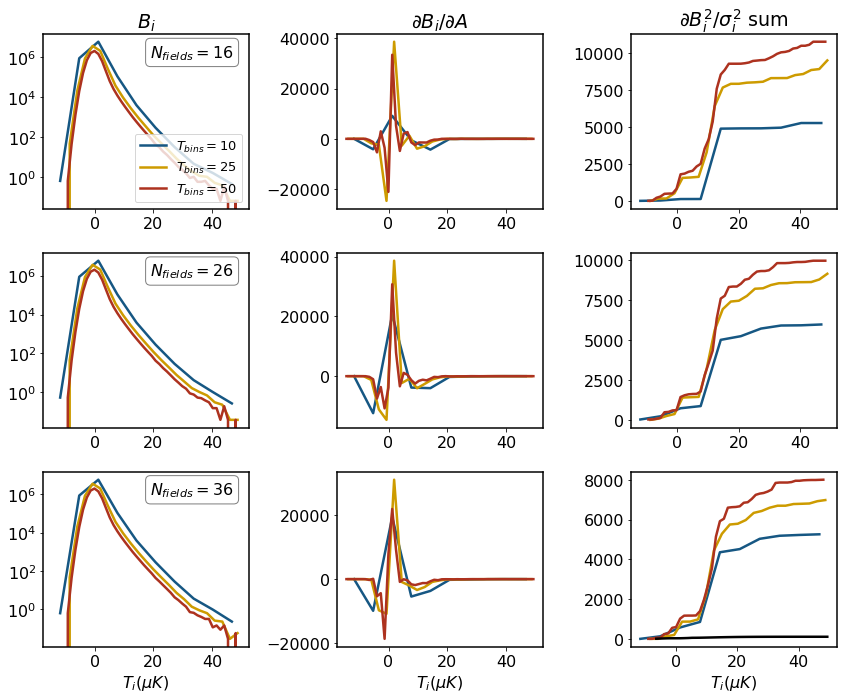

In [135]:
Nvox=LC.Nchan*LC.Npix

plt.figure(figsize=(12,10))
plt.subplot(3,3,1)
plt.plot(T10, Bi_N10[0], label='$T_{bins}=10$')
plt.plot(T25, Bi_N25[0], label='$T_{bins}=25$')
plt.plot(T50, Bi_N50[0], label='$T_{bins}=50$')
plt.yscale('log')
plt.legend(fontsize=13, loc='lower right')
plt.title('$B_i$')
plt.text(19, 1e6, '$N_{fields} = 16$', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.subplot(3,3,2)
plt.plot(T10, deriv_N10[0])
plt.plot(T25, deriv_N25[0])
plt.plot(T50, deriv_N50[0])
plt.title('$\partial B_i/\partial A$')

plt.subplot(3,3,3)
mask10=(Bi_N10[0])>0
varBi10=np.asarray((Bi_N10[0])[mask10]*(1-(Bi_N10[0])[mask10]/Nvox))
mask25=(Bi_N25[0])>0
varBi25=np.asarray((Bi_N25[0])[mask25]*(1-(Bi_N25[0])[mask25]/Nvox))
mask50=(Bi_N50[0])>0
varBi50=np.asarray((Bi_N50[0])[mask50]*(1-(Bi_N50[0])[mask50]/Nvox))
plt.plot(T10[mask10], np.cumsum((deriv_N10[0])[mask10]**2/varBi10))
plt.plot(T25[mask25], np.cumsum((deriv_N25[0])[mask25]**2/varBi25))
plt.plot(T50[mask50], np.cumsum((deriv_N50[0])[mask50]**2/varBi50))
plt.title('$\partial B_i^2/\sigma_i^2$ sum')

plt.subplot(3,3,4)
plt.plot(T10, Bi_N10[1])
plt.plot(T25, Bi_N25[1])
plt.plot(T50, Bi_N50[1])
plt.yscale('log')
plt.text(19, 1e6, '$N_{fields} = 26$', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.subplot(3,3,5)
plt.plot(T10, deriv_N10[1])
plt.plot(T25, deriv_N25[1])
plt.plot(T50, deriv_N50[1])

plt.subplot(3,3,6)
mask10=(Bi_N10[1])>0
varBi10=np.asarray((Bi_N10[1])[mask10]*(1-(Bi_N10[1])[mask10]/Nvox))
mask25=(Bi_N25[1])>0
varBi25=np.asarray((Bi_N25[1])[mask25]*(1-(Bi_N25[1])[mask25]/Nvox))
mask50=(Bi_N50[1])>0
varBi50=np.asarray((Bi_N50[1])[mask50]*(1-(Bi_N50[1])[mask50]/Nvox))
plt.plot(T10[mask10], np.cumsum((deriv_N10[1])[mask10]**2/varBi10))
plt.plot(T25[mask25], np.cumsum((deriv_N25[1])[mask25]**2/varBi25))
plt.plot(T50[mask50], np.cumsum((deriv_N50[1])[mask50]**2/varBi50))

plt.subplot(3,3,7)
plt.plot(T10, Bi_N10[2])
plt.plot(T25, Bi_N25[2])
plt.plot(T50, Bi_N50[2])
plt.yscale('log')
plt.xlabel('$T_i (\mu K)$')
plt.text(19, 1e6, '$N_{fields} = 36$', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.subplot(3,3,8)
plt.plot(T10, deriv_N10[2])
plt.plot(T25, deriv_N25[2])
plt.plot(T50, deriv_N50[2])
plt.xlabel('$T_i (\mu K)$')

plt.subplot(3,3,9)
mask10=(Bi_N10[2])>0
varBi10=np.asarray((Bi_N10[2])[mask10]*(1-(Bi_N10[2])[mask10]/Nvox))
mask25=(Bi_N25[2])>0
varBi25=np.asarray((Bi_N25[2])[mask25]*(1-(Bi_N25[2])[mask25]/Nvox))
mask50=(Bi_N50[2])>0
varBi50=np.asarray((Bi_N50[2])[mask50]*(1-(Bi_N50[2])[mask50]/Nvox))
plt.plot(T10[mask10], np.cumsum((deriv_N10[2])[mask10]**2/varBi10))
plt.plot(T25[mask25], np.cumsum((deriv_N25[2])[mask25]**2/varBi25))
plt.plot(T50[mask50], np.cumsum((deriv_N50[2])[mask50]**2/varBi50))

plt.xlabel('$T_i (\mu K)$')
plt.tight_layout()

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


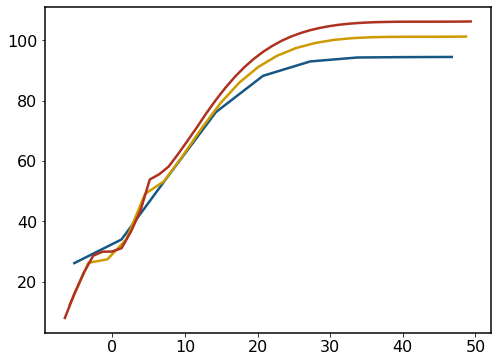

In [136]:
varBi10_LIM=Bi_Nbins[0]*(1-Bi_Nbins[0]/m_bwc.Nvox)
mask10=varBi10_LIM!=0
plt.plot(T10[mask10], np.cumsum((deriv_LIM[0]**2/varBi10_LIM)[mask10]))

varBi25_LIM=Bi_Nbins[1]*(1-Bi_Nbins[1]/m_bwc.Nvox)
mask25=varBi25_LIM!=0
plt.plot(T25[mask25], np.cumsum((deriv_LIM[1]**2/varBi25_LIM)[mask25]))

varBi50_LIM=Bi_Nbins[2]*(1-Bi_Nbins[2]/m_bwc.Nvox)
mask50=varBi50_LIM!=0
plt.plot(T50[mask50], np.cumsum((deriv_LIM[2]**2/varBi50_LIM)[mask50]))

### Total lightcone

Full $\Omega_{field}=400$ deg$^2$ lightcone

In [11]:
model_bwc=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=10**Mh_bwc)
LC = make_measurements(LC_params(True, 'Dongwoo_SFR', model_bwc, 10))

In [12]:
bwc_map=np.asarray(LC.obs_3d_map)
tot_map=bwc_map[:,:-10,:-10] #cut out weird edge effect

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [35]:
Ncut=6
map_cut=[]
for i in range(Ncut):
    for j in range(Ncut):
        map_cut.append(tot_map[:,int((i*len(tot_map[0])/6)):int(((i+1)*len(tot_map[0])/6-1)),
                               int((j*len(tot_map[0])/6)):int(((j+1)*len(tot_map[0])/6-1))])
map_cut=np.asarray(map_cut)

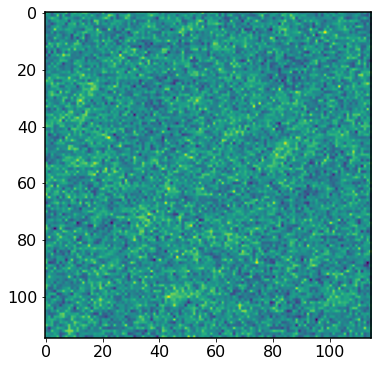

In [38]:
plt.imshow(np.sum(map_cut[20], axis=0))

In [40]:
LC.update(SFR_pars=dict(A=A_bwc*(1.05), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
map_plus=np.asarray(LC.obs_3d_map)[:,:-10,:-10]

LC.update(SFR_pars=dict(A=A_bwc*(0.95), B=B_bwc, C=C_bwc, M_h=10**Mh_bwc))
map_minus=np.asarray(LC.obs_3d_map)[:,:-10,:-10]

In [46]:
Ti_edge=np.linspace(-20, 50, 30)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

Ncut=6
deriv_cut=[]
for i in range(Ncut):
    for j in range(Ncut):
        plus_cut=map_plus[:,int((i*len(map_plus[0])/6)):int(((i+1)*len(map_plus[0])/6-1)),
                                 int((j*len(map_plus[0])/6)):int(((j+1)*len(map_plus[0])/6-1))]
        minus_cut=map_minus[:,int((i*len(map_minus[0])/6)):int(((i+1)*len(map_minus[0])/6-1)),
                                   int((j*len(map_minus[0])/6)):int(((j+1)*len(map_minus[0])/6-1))]
        Bi_plus=np.histogram(plus_cut.flatten(), bins=Ti_edge)[0]
        Bi_minus=np.histogram(minus_cut.flatten(), bins=Ti_edge)[0]
        deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))

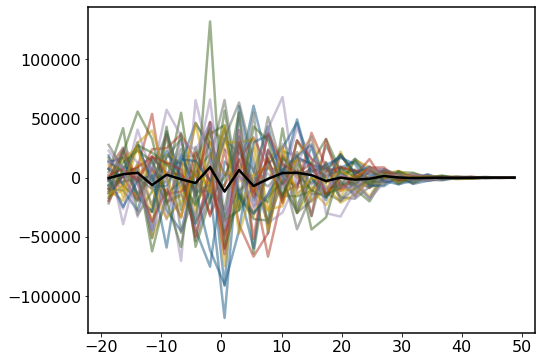

In [47]:
for i in range(36):
    plt.plot(Ti, deriv_cut[i], alpha=0.5)
plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
#plt.xscale('log')

In [59]:
np.arange(36)[:9]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [51]:
Nvox=LC.Nchan*LC.Npix/36

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted 

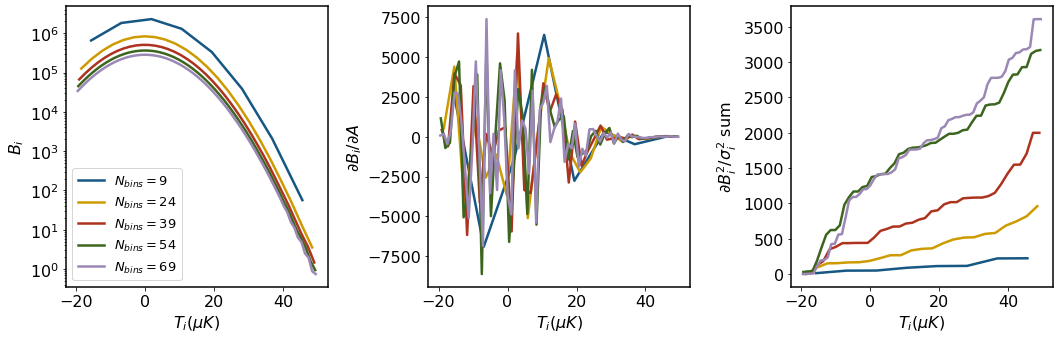

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, Bi_bins[n], label='$N_{bins}=$'+str(Nbins[n]))
plt.yscale('log')
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$B_i$')
plt.legend(fontsize=13)

plt.subplot(1,3,2)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

    plt.plot(Ti, deriv_bins[n])
#plt.yscale('log')
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$\partial B_i/\partial A$')

plt.subplot(1,3,3)
for n in range(len(Nbins)):
    Ti_edge=np.linspace(-20, 50, Nbins[n])
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    
    mask=[(Bi_bins[n])>0]
    varBi=np.asarray((Bi_bins[n])[mask]*(1-(Bi_bins[n])[mask]/Nvox))
    plt.plot(Ti[mask], np.cumsum((deriv_bins[n])[mask]**2/varBi))
plt.xlabel('$T_i (\mu K)$')
plt.ylabel('$\partial B_i^2/\sigma_i^2$ sum')
plt.tight_layout()

In [49]:
Ti_edge=np.linspace(-20, 50, n)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

Nbins=[9, 24, 39, 54, 69]
Nfields=[4, 9, 16, 25, 36]
Bi_bins=np.zeros((len(Nfields), len(Nbins), len(Ti)))
deriv_bins=np.zeros((len(Nfields), len(Nbins), len(Ti)))
for n in Nbins:   
    Bi_cut=[]
    deriv_cut=[]
    for i in range(Ncut):
        for j in range(Ncut):
            map_cut=tot_map[:,int((i*len(tot_map[0])/6)):int(((i+1)*len(tot_map[0])/6-1)),
                            int((j*len(tot_map[0])/6)):int(((j+1)*len(tot_map[0])/6-1))]
            plus_cut=map_plus[:,int((i*len(map_plus[0])/6)):int(((i+1)*len(map_plus[0])/6-1)),
                              int((j*len(map_plus[0])/6)):int(((j+1)*len(map_plus[0])/6-1))]
            minus_cut=map_minus[:,int((i*len(map_minus[0])/6)):int(((i+1)*len(map_minus[0])/6-1)),
                                int((j*len(map_minus[0])/6)):int(((j+1)*len(map_minus[0])/6-1))]
            Bi_plus=np.histogram(plus_cut.flatten(), bins=Ti_edge)[0]
            Bi_minus=np.histogram(minus_cut.flatten(), bins=Ti_edge)[0]
            deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))
            Bi_cut.append(np.histogram((map_cut).flatten(), bins=Ti_edge)[0])
    for f in range(len(Nfields)):
        Bi_bins[f]=np.average(Bi_cut[:Nfields[f]], axis=0)
        deriv_bins[f]=np.average(deriv_cut[:f], axis=0)

### Working with the saved derivative subfield maps

In [18]:
maps_plus=np.load('../../maps_cut_Aplus.npy')
maps_minus=np.load('../../maps_cut_Aminus.npy')
maps_cut=np.load('../../maps_cut_fid.npy')

In [19]:
Ti_edge=np.linspace(-15, 50, 51)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

deriv_cut=[]
Bi_cut=[]
for i in range(len(maps_cut)):
    Bi_plus=np.histogram(maps_plus[i].flatten(), bins=Ti_edge)[0]
    Bi_minus=np.histogram(maps_minus[i].flatten(), bins=Ti_edge)[0]
    deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))
    Bi_cut.append(np.histogram(maps_cut[i].flatten(), bins=Ti_edge)[0])

In [37]:
#analytical result
bwc_plus=dict(A=A_bwc*1.05, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_plus))
_, Bi_LIMplus=get_VID(m_bwc, 50)
print(m_bwc.model_par['SFR_pars'])

bwc_minus=dict(A=A_bwc*0.95, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_minus))
Ti_bwc, Bi_LIMminus=get_VID(m_bwc, 50)
print(m_bwc.model_par['SFR_pars'])

deriv_LIM=(Bi_LIMplus-Bi_LIMminus)/(A_bwc*0.1)

bwc_fid=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_fid))
Ti_bwc, Bi_LIM=get_VID(m_bwc, 50)
print(m_bwc.model_par['SFR_pars'])

{'A': 0.32580932649220684, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': <Quantity 2.33635185e+12 solMass>}
{'A': 0.2947798668262823, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': <Quantity 2.33635185e+12 solMass>}
{'A': 0.3102945966592446, 'B': -2.0242077825756883, 'C': 197.03972185646646, 'M_h': <Quantity 2.33635185e+12 solMass>}


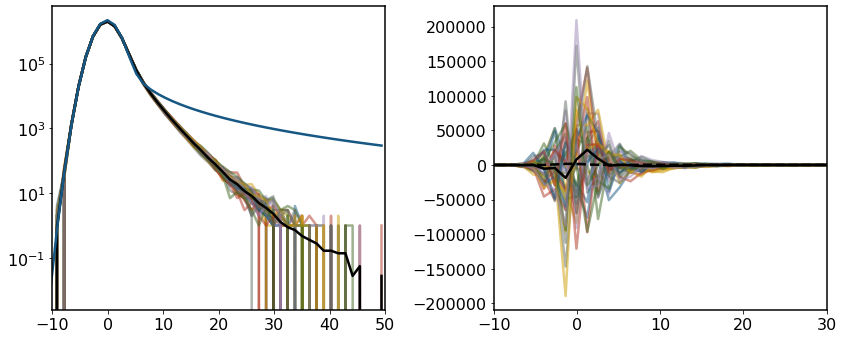

In [38]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i in range(len(Bi_cut)):
    plt.plot(Ti, Bi_cut[i], alpha=0.5)
plt.plot(Ti, np.average(Bi_cut, axis=0), 'k')
plt.plot(Ti_bwc, Bi_LIM)
plt.yscale('log')
plt.xlim(-10, 50)

plt.subplot(1,2,2)
for i in range(len(deriv_cut)):
    plt.plot(Ti, deriv_cut[i], alpha=0.5)
plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)
plt.tight_layout()

In [28]:
Nbins=[20,30,40,50]
deriv_Nbins=[]
Bi_Nbins=[]
cumsum_Nbins=[]
cumsumdiag_Nbins=[]
Ti_Nbins=[]
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

    deriv_cut=[]
    Bi_cut=[]
    for j in range(len(maps_cut)):
        Bi_plus=np.histogram(maps_plus[j].flatten(), bins=Ti_edge)[0]
        Bi_minus=np.histogram(maps_minus[j].flatten(), bins=Ti_edge)[0]
        deriv_cut.append((Bi_plus-Bi_minus)/(A_bwc*0.1))
        Bi_cut.append(np.histogram(maps_cut[j].flatten(), bins=Ti_edge)[0])
    Bi=np.average(Bi_cut, axis=0)
    deriv=np.average(deriv_cut, axis=0)
    
    Bi_Nbins.append(Bi)
    deriv_Nbins.append(deriv)
    
    cov=np.zeros((len(Ti), len(Ti)))
    cov_diag=np.zeros((len(Ti), len(Ti)))
    for ik in range(len(Ti)):
        for jk in range(ik, len(Ti)):
            if ik==jk:
                if Bi[ik]==0:
                    Bi_cov=1
                else:
                    Bi_cov=Bi[ik]
                cov[ik,jk]=Bi_cov*(1-Bi_cov/m_bwc.Nvox)
                cov_diag[ik,jk]=Bi_cov*(1-Bi_cov/m_bwc.Nvox)
            else:
                if Bi[ik]==0:
                    Bi_cov=1
                else:
                    Bi_cov=Bi[ik]
                if Bi[jk]==0:
                    Bj_cov=1
                else:
                    Bj_cov=Bi[jk]

                cov[ik,jk]=-Bi_cov*Bj_cov/m_bwc.Nvox
                cov[jk,ik]=cov[ik,jk]
                
    cumsum=[]
    cumsum_diag=[]
    for t in range(1, len(Bi)+1):
        subcov=cov[:t,:t]
        subcov_diag=cov_diag[:t,:t]
        
        covinv=np.linalg.inv(subcov)
        covinv_diag=np.linalg.inv(subcov_diag)
        
        subderiv=deriv[:t]
        cumsum.append(np.einsum('i,ij,j->',subderiv,covinv,subderiv))
        cumsum_diag.append(np.einsum('i,ij,j->',subderiv,covinv_diag,subderiv))

    cumsum_Nbins.append(cumsum)
    cumsumdiag_Nbins.append(cumsum_diag)

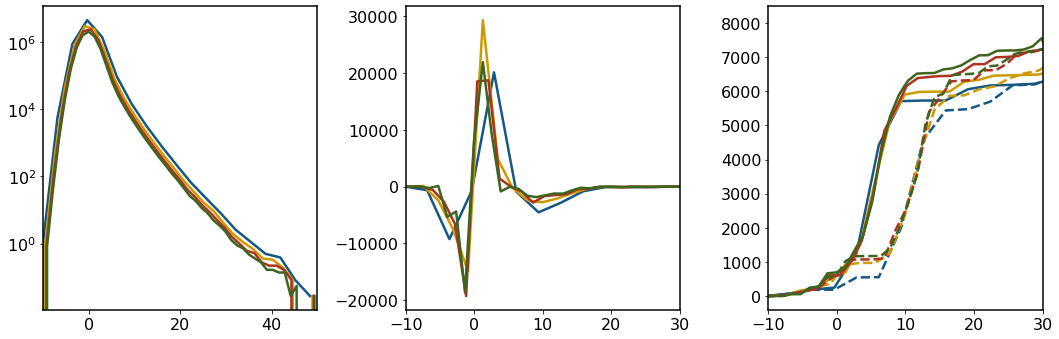

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, Bi_Nbins[i])
#plt.plot(Ti, np.average(Bi_cut, axis=0), 'k')
#plt.plot(Ti_bwc, Bi_LIM)
plt.yscale('log')
plt.xlim(-10, 50)

plt.subplot(1,3,2)
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, deriv_Nbins[i])
#plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
#plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)

plt.subplot(1,3,3)
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, cumsum_Nbins[i], color=palette[i])
    plt.plot(Ti, cumsumdiag_Nbins[i], '--', color=palette[i])

#plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
#plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)
plt.tight_layout()

In [64]:
Bi_LIMplus.shape

(20,)

In [15]:
Nbins=[20,30,40,50]

derivLIM_Nbins=[]
BiLIM_Nbins=[]
cumsumLIM_Nbins=[]
cumsumdiagLIM_Nbins=[]
TiLIM_Nbins=[]
for i in range(len(Nbins)):
    bwc_plus=dict(A=A_bwc*1.05, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_plus))
    _, Bi_LIMplus=get_VID(m_bwc, Nbins[i])

    bwc_minus=dict(A=A_bwc*0.95, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_minus))
    _, Bi_LIMminus=get_VID(m_bwc, Nbins[i])

    derivLIM=(Bi_LIMplus-Bi_LIMminus)/(A_bwc*0.1)
    derivLIM_Nbins.append(derivLIM)
    
    bwc_fid=dict(A=A_bwc, B=B_bwc, C=C_bwc, M_h=(10**Mh_bwc)*u.Msun)
    m_bwc.update(model_par=dict(alpha=1.37, beta=-1.74, dMF=1.0, SFR_file='Chung',sig_SFR=0.5, SFR_pars=bwc_fid))
    Ti_LIM, Bi_LIM=get_VID(m_bwc, Nbins[i])
    
    BiLIM_Nbins.append(Bi_LIM)
    
    cov_LIM=np.zeros((len(Ti_LIM), len(Ti_LIM)))
    covdiag_LIM=np.zeros((len(Ti_LIM), len(Ti_LIM)))
    for ik in range(len(Ti_LIM)):
        for jk in range(ik, len(Ti_LIM)):
            if ik==jk:
                cov_LIM[ik,jk]=Bi_LIM[ik]*(1-Bi_LIM[ik]/m_bwc.Nvox)
                covdiag_LIM[ik,jk]=Bi_LIM[ik]*(1-Bi_LIM[ik]/m_bwc.Nvox)
            else:
                cov_LIM[ik,jk]=-Bi_LIM[ik]*Bi_LIM[jk]/m_bwc.Nvox
                cov_LIM[jk,ik]=cov_LIM[ik,jk]    
    
    mask=Bi_LIM>=1
    cov_mask=cov_LIM[mask][:,mask]
    covdiag_mask=covdiag_LIM[mask][:,mask]
    cumsum=[]
    cumsum_diag=[]
    for t in range(1, len(Bi_LIM[mask])+1):
        subcov=cov_mask[:t,:t]
        subcov_diag=covdiag_mask[:t,:t]        
        covinv=np.linalg.inv(subcov)
        covinv_diag=np.linalg.inv(subcov_diag)
        
        subderiv=(derivLIM[mask])[:t]
        cumsum.append(np.einsum('i,ij,j->',subderiv,covinv,subderiv))
        cumsum_diag.append(np.einsum('i,ij,j->',subderiv,covinv_diag,subderiv))
    cumsumLIM_Nbins.append(cumsum)
    cumsumdiagLIM_Nbins.append(cumsum_diag)
    TiLIM_Nbins.append(Ti_LIM[mask])

/home-2/gsatopo1@jhu.edu/library/my_lim/source/tools/_vid_tools.py:77: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  h[ii] = quad(PTi,Tedge[ii].value,Tedge[ii+1].value)[0]*Nvox
/home-2/gsatopo1@jhu.edu/library/my_lim/source/tools/_vid_tools.py:77: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  h[ii] = quad(PTi,Tedge[ii].value,Tedge[ii+1].value)[0]*Nvox


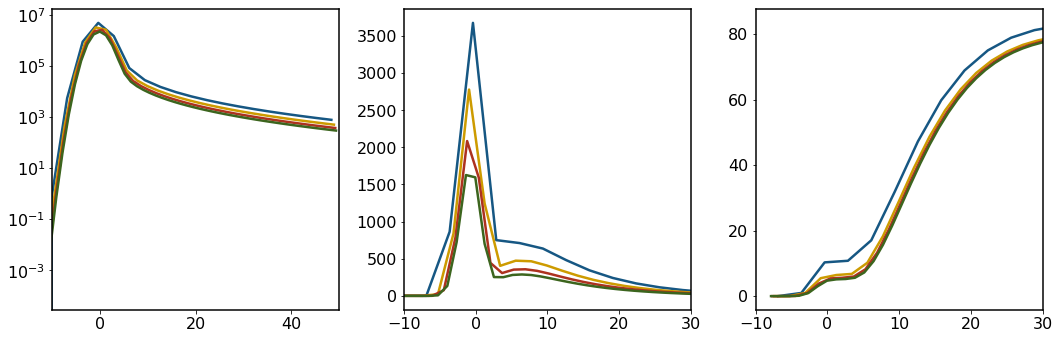

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, BiLIM_Nbins[i])
#plt.plot(Ti, np.average(Bi_cut, axis=0), 'k')
#plt.plot(Ti_bwc, Bi_LIM)
plt.yscale('log')
plt.xlim(-10, 50)

plt.subplot(1,3,2)
for i in range(len(Nbins)):
    Ti_edge=np.linspace(-15, 50, Nbins[i]+1)
    Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.
    plt.plot(Ti, derivLIM_Nbins[i])
#plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
#plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)

plt.subplot(1,3,3)
for i in range(len(Nbins)):
    #plt.plot(TiLIM_Nbins[i], cumsumLIM_Nbins[i], color=palette[i])
    plt.plot(TiLIM_Nbins[i], cumsumdiagLIM_Nbins[i], color=palette[i])

#plt.plot(Ti, np.average(deriv_cut, axis=0), 'k')
#plt.plot(Ti_bwc, deriv_LIM, '--k')
plt.xlim(-10, 30)
plt.tight_layout()